**Boston Airbnb**¶


In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline

In [2]:
# Import data
url1= 'https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/calendar.csv'
url2= 'https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/reviews.csv'
url3='https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/listings.csv'


df_calendar = pd.read_csv(url1)
df_reviews = pd.read_csv(url2)
df_listings = pd.read_csv(url3)


**Business Understanding**

1. What are the most common listings
2. What type of property has higher listing price?
3. What is the price distribution?
4. What features correlate with price?
5. What's important to tenants


**Data Preparation**


In [3]:
df_reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [4]:
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [5]:
df_listings.describe()


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,8.516813e-01,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


In [6]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Data Quality Issues to be fixed:
- fixing object type
- removing columns with majority of missing data
- removing rows for bedroom, bathroom, accomodates where value is zero
- for some columns complete NA values with mean

In [7]:
# Missing values
missing_values = df_listings.isnull().sum()
percent_missing_values = (missing_values/len(df_listings))*100
percent_missing_values.sort_values(ascending=False)

neighbourhood_group_cleansed        100.000000
jurisdiction_names                  100.000000
license                             100.000000
has_availability                    100.000000
square_feet                          98.437936
monthly_price                        75.230126
weekly_price                         75.118550
security_deposit                     62.566248
notes                                55.090656
interaction                          43.347280
access                               41.534170
neighborhood_overview                39.470014
host_about                           36.513250
transit                              35.983264
house_rules                          33.249651
cleaning_fee                         30.878661
space                                29.483961
review_scores_accuracy               22.956764
review_scores_location               22.928870
review_scores_value                  22.900976
review_scores_checkin                22.873082
review_scores

In [8]:
# Droping columns with majority missing values
outliers_columns=percent_missing_values[percent_missing_values>80]
outliers_columns

neighbourhood_group_cleansed    100.000000
square_feet                      98.437936
has_availability                100.000000
license                         100.000000
jurisdiction_names              100.000000
dtype: float64

In [9]:
df_listings = df_listings.drop(['neighbourhood_group_cleansed',
 'square_feet',
 'has_availability',
 'license',
 'jurisdiction_names'], axis=1)

In [10]:
# format price column
df_listings.price = df_listings.price.str.lstrip('$').str.replace(',', '').astype('float')


In [11]:
# Drop rows with price <= 0, bathrooms < 1, bedrooms <=0, accommodates <= 0
df_listings = df_listings[df_listings.price > 0]
df_listings = df_listings[df_listings.bathrooms >= 1]
df_listings = df_listings[df_listings.bedrooms > 0]
df_listings = df_listings[df_listings.accommodates > 0]


In [12]:
# Convert number of bathrooms, bedrooms, accommodates to int
df_listings.bathrooms = df_listings.bathrooms.astype('int')
df_listings.bedrooms = df_listings.bedrooms.astype('int')
df_listings.accommodates = df_listings.accommodates.astype('int')


In [13]:
# extract the number of amenities 
df_listings['n_amenities'] = df_listings['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
df_listings.drop('amenities', axis=1, inplace=True)

In [14]:
# Subtrack numberical columns  for correlation and drop unused columns

listings_num = df_listings.select_dtypes(include=['int', 'float'])


listings_num = listings_num.drop(['host_listings_count', 'host_total_listings_count', 'id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'reviews_per_month'], axis=1)


In [15]:
# Fill null values with mean and convert values to int
cols = ['n_amenities', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
for col in cols:
    listings_num[col].fillna(value=listings_num[col].mean(), inplace=True)

for col in cols:
    listings_num[col] = listings_num[col].astype('float64').astype('int64')
listings_num[cols].dtypes

n_amenities                    int64
beds                           int64
price                          int64
review_scores_rating           int64
review_scores_accuracy         int64
review_scores_cleanliness      int64
review_scores_checkin          int64
review_scores_communication    int64
review_scores_location         int64
review_scores_value            int64
dtype: object

**Data Exploration**

**1) What are the most common listings**

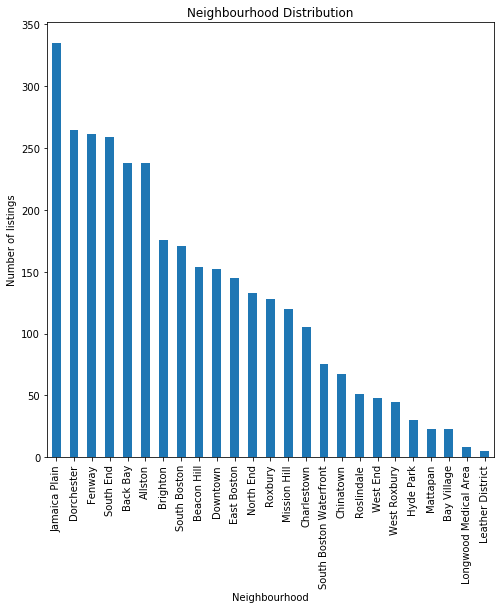

In [16]:
df_listings.neighbourhood_cleansed.value_counts()

df_listings.neighbourhood_cleansed.value_counts().plot.bar(title = 'Neighbourhood Distribution', figsize = (8,8))
plt.xlabel('Neighbourhood');
plt.ylabel('Number of listings');
plt.savefig("fig1.png", bbox_inches = 'tight') # save as png


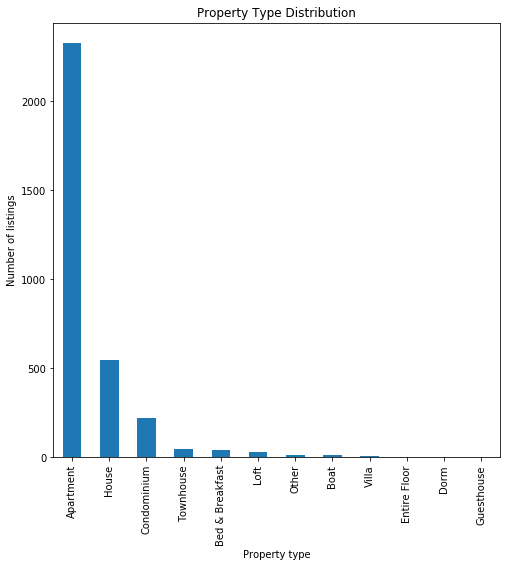

In [17]:
df_listings.property_type.value_counts().plot.bar(title = 'Property Type Distribution', figsize = (8,8))
plt.xlabel('Property type');
plt.ylabel('Number of listings');
plt.savefig("fig2.png", bbox_inches = 'tight') # save as png

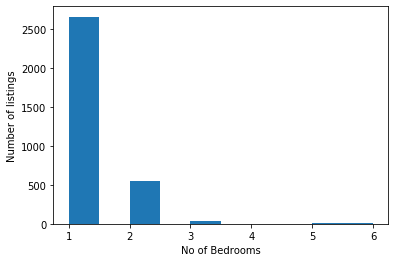

In [18]:
plt.hist(df_listings['bathrooms'])
plt.xlabel('No of Bedrooms');
plt.ylabel('Number of listings');
plt.savefig("fig3.png", bbox_inches = 'tight') # save as png

The most common listings are for one bedroom apartments. Most properties are in Jamaica Plain and the least in Leather District.

**2) What type of property has higher listing price?**

In [19]:
def heatmap_for_price(col_list):
    '''
    This function creates heatmap of price against given combinations of features
    
    INPUT
    col_list - list of columns against which price heatmap is to be generated
    
    OUTPUT
    plt: heatmap of given size and title
    
    '''
    plt.figure(figsize=(12,12))
    sns.heatmap(df_listings.groupby(col_list).price.mean().unstack(),annot=True, fmt=".2f");
    plt.title('Price heatmap by {}'.format(col_list))

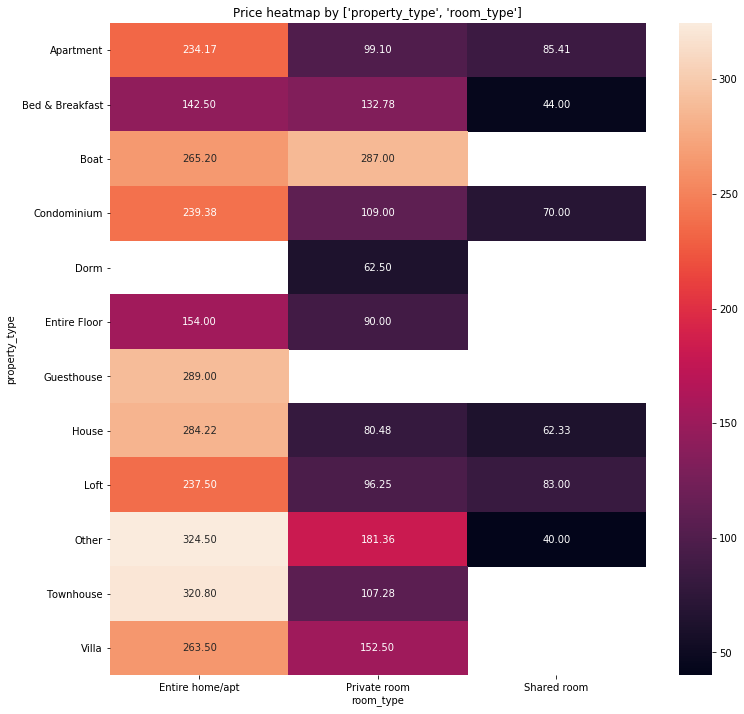

In [20]:
heatmap_for_price(['property_type', 'room_type'])
plt.savefig("fig4.png", bbox_inches = 'tight') # save as png

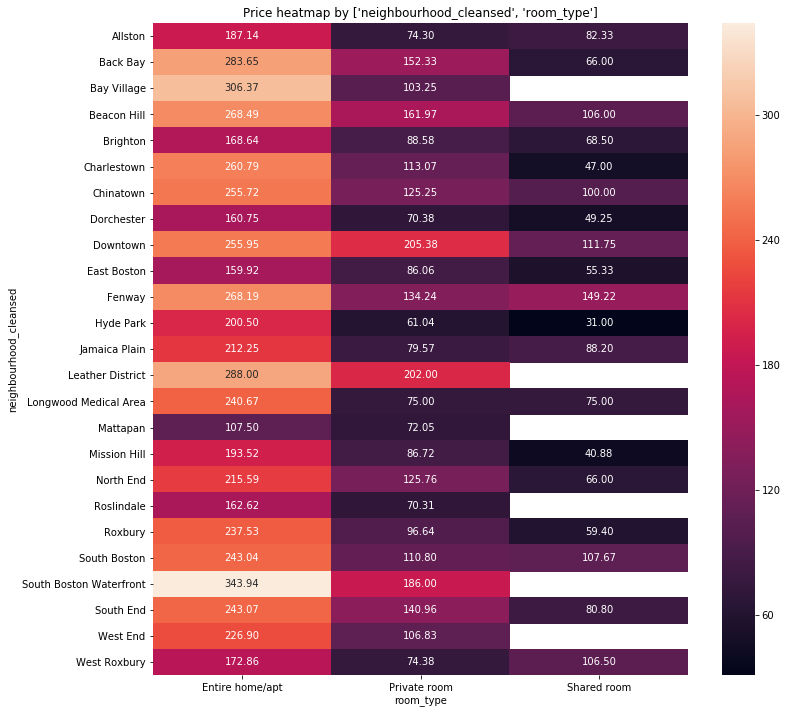

In [21]:
heatmap_for_price(['neighbourhood_cleansed','room_type'])
plt.savefig("fig5.png", bbox_inches = 'tight') # save as png

Highest average price lies with townhouse when renting the whole property and interestingly with boar where private room can be rented. When it comes to the neighbourhood, the most expensive one is South Boston Waterfront followed by Bay Village. However, it has to be noted that most expensive locations are not where majority of listings are. Jamaica Plain with one bedroom, which was the location with the most listings is on lower scale of average prices.

In [22]:
# Most expensive street
price_by_street = df_listings.groupby('street').price.mean()
price_by_street.sort_values(ascending=False).head(1)


street
Myrtle Street, unit, Boston, MA 02114, United States    1345.0
Name: price, dtype: float64

**3) What is the price distribution?**

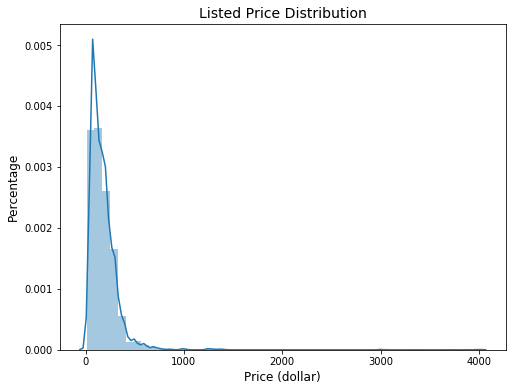

In [23]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.distplot(listings_num['price'], bins=50, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price (dollar)', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14)
plt.savefig("fig6.png", bbox_inches = 'tight') # save as png;

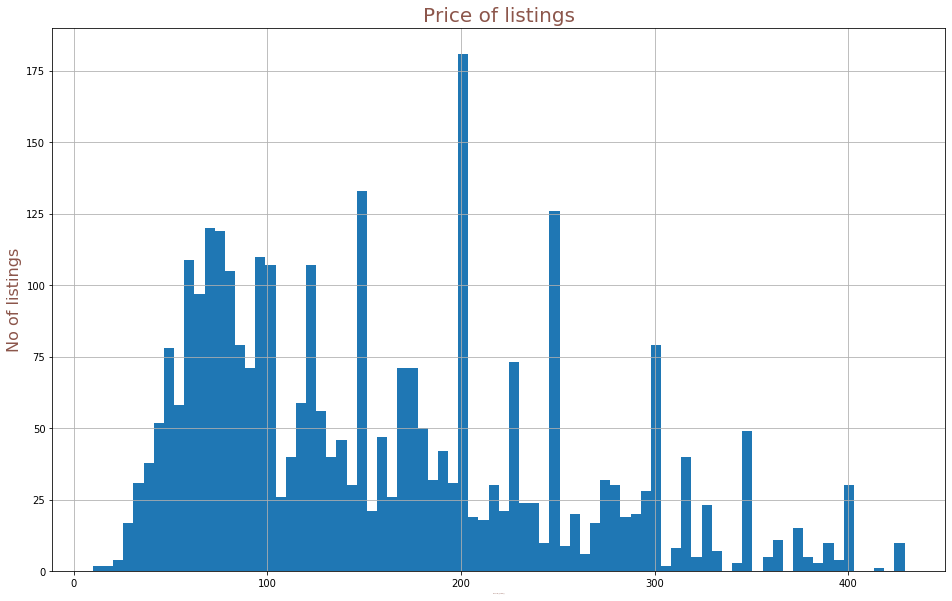

In [24]:
plt.figure(figsize=(16, 10));
listings_num[listings_num['price'] < 430]['price'].hist(bins=80); # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
plt.title('Price of listings', size = 20,  color='C5');
plt.ylabel('No of listings', size =16, color='C5');
plt.xlabel('Price (USD)', size = 2, color='C5');
plt.savefig("fig7.png", bbox_inches = 'tight') # save as png;

In [25]:
listings_num['price'].mean()


176.02242703533025

In [26]:
listings_num['price'].median()


150.0

We can see that there are some locations with extremely high or low price, however typical price for a property is around £150.

**4) What correlates with a price?**

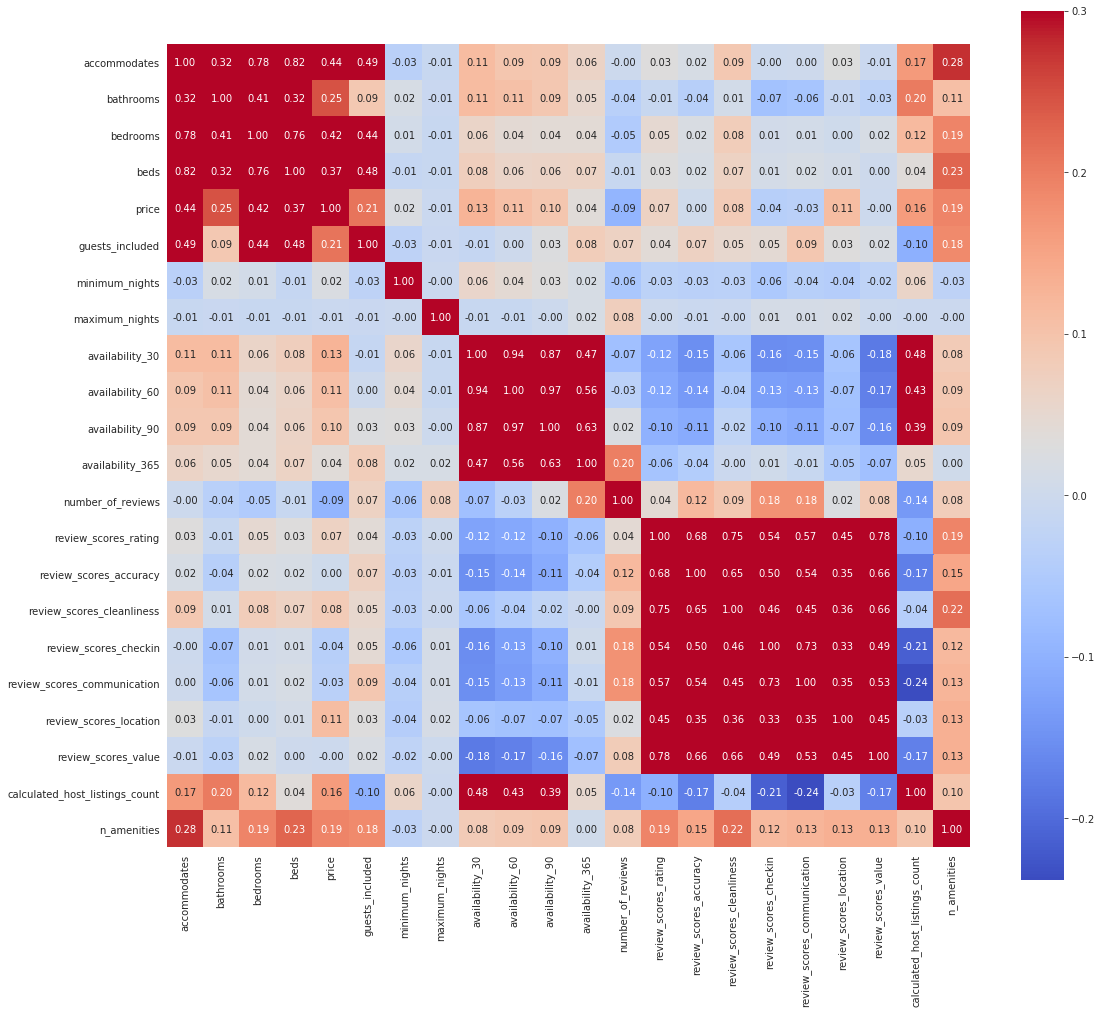

In [27]:
# visualize the correlation matrix
corr = listings_num.corr()
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 16))
    ax = sns.heatmap(corr, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
    plt.savefig("fig8.png", bbox_inches = 'tight') # save as png;

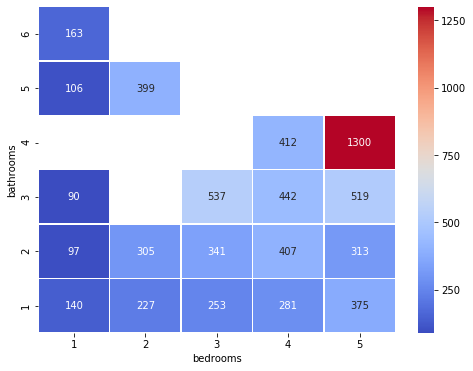

In [28]:
# Average price based on no of bedrooms and bathrooms
plt.figure(figsize=(8, 6))
sns.heatmap(listings_num.groupby(['bathrooms', 'bedrooms']).mean()['price'].reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap="coolwarm", fmt='.0f', annot=True, linewidths=0.5);
plt.savefig("fig9.png", bbox_inches = 'tight') # save as png;

It's probably no surprise that what correlates with the price is the size of the property defined by no of bedroom, bathroom and accomodates. When looking at average prices based on no of bathrooms and bedrooms there is high price for a property with 3 bedrooms and 3 bathrooms. It's also interesting that having a property with 2 or 3 bedrooms and 1 bedroom doesn't make a big difference in renting price.

**5) Features that matters**

In [29]:
# Define a function to generate wordcloud.
from functools import reduce
def generate_wordcould(text_list):
    """generate and visulize a text vector that in list-like form
    
       INPUT
       text_list - a list of strings
       OUTPUT
       plt - a plot showing text occurances (text size is directly proportional to frequency)
    """
    text = reduce((lambda x, y: x+y), text_list)
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

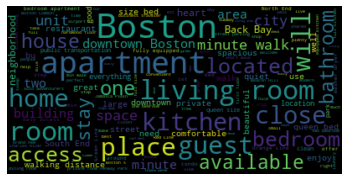

In [30]:
# Get vocabulary of reviews from house descriptions.
generate_wordcould(df_listings['description'])


In [31]:
# get vocabulary of reviews from df_reviews
reviews = df_reviews[df_reviews['comments'].notnull()]


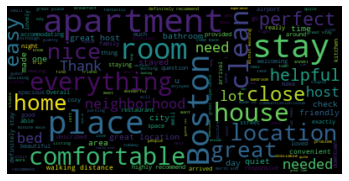

In [32]:
generate_wordcould(reviews['comments'])

Among other things, home owners emphasize room types, property types, neighborhood, bed sizes, comfort and distance proximity while tenants comment in their reviews about the host, location and cleanliness.